In [87]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import OrderedDict
from fractions import Fraction
from functools import reduce
from math import gcd
from IPython.display import display, Markdown, Latex
import copy
import networkx as nx
import pylab
from networkx.drawing.nx_agraph import graphviz_layout

In [88]:
def plot_feasible(A, b, dmax):
    
    def is_extreme_point():
        if p not in extreme_points:
            flag = (p[0] >= 0) & (p[1] >= 0)
            for k in range(A.shape[0]):
                flag = flag & (A[k, 0]*p[0] + A[k, 1]*p[1] <= b[k])
            if flag == True:
                extreme_points.append(p)
                plt.scatter(p[0], p[1])
                
    plt.figure(figsize=(20,10))
    d = np.linspace(0, dmax, 300)
    x, y = np.meshgrid(d, d)
    constraints = [(A[i, 0]*x + A[i, 1]*y <= b[i]) for i in range(A.shape[0])]
    region = (x >= 0) & (y >= 0)
    for expr in constraints:
        region = region & expr
    plt.imshow( (region).astype(int) , 
                    extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3);


    # plot the lines defining the constraints
    x = np.linspace(0, dmax, 2000)
    extreme_points = []
    for i in range(A.shape[0]):
        if A[i, 1]!=0:
            if A[i, 0]!=0:
                line = (b[i] - A[i, 0]*x)/A[i, 1]
                plt.plot(x, line, label=f'${{{A[i, 0]}}}x+{{{A[i, 1]}}}y\leq{{{b[i]}}}$')
                p = (b[i] / A[i, 0], 0)
                is_extreme_point()
                p = (0, b[i] / A[i, 1])
                is_extreme_point()
                
            else:
                plt.axhline(y=b[i]/A[i, 1], label=f'${{{A[i, 1]}}}y\leq{{{b[i]}}}$')
                p = (0, b[i] / A[i, 1])
                is_extreme_point()
                
        else:
            plt.axvline(x=b[i]/A[i, 0], label=f'${{{A[i, 0]}}}x\leq{{{b[i]}}}$')
            p = (b[i] / A[i, 0], 0)
            is_extreme_point()
        
        for j in range(i+1, A.shape[0]):
            if (A[i, 0] * A[j, 1] - A[i, 1] * A[j, 0]) != 0:
                p = ((A[j, 1] * b[i] - A[i, 1] * b[j])/(A[i, 0] * A[j, 1] - A[i, 1] * A[j, 0]), 
                     (A[i, 0] * b[j] - A[j, 0] * b[i])/(A[i, 0] * A[j, 1] - A[i, 1] * A[j, 0]))
                is_extreme_point()

    plt.xlim(0,dmax)
    plt.ylim(0,dmax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    return extreme_points

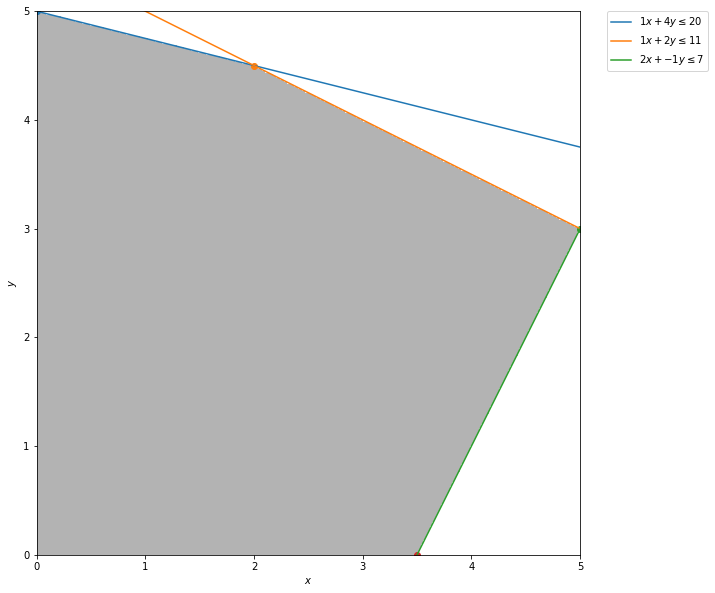

In [89]:
A = np.array([[1, 4],[1, 2], [2, -1]])
b = [20, 11, 7]
extreme_points = plot_feasible(A, b, 5)

In [92]:
class SimplexSolver:
    def __init__(self, A, b, c, symbol=None):
        self.A = A.copy().astype(float)
        self.b = b.copy().astype(float)
        self.c = c.copy().astype(float)
        self.symbol = symbol
        self.basis = []
        self.slack = None
        self.z = None
        self.obj = None

    def add_constraints(self, new_A, new_b):
        """Only call add_constraints after solve the LP once. Otherwise please initialize another solver."""
        """Assume in the form Ax <= b"""
        """A: m by n numpy array; b: n numpy array"""
        m, n = self.A.shape
        new_m, new_n = new_A.shape
        zeros = np.zeros((new_m, n - new_n))
        A_new = np.c_[new_A, zeros]
        b_new = new_b.copy()
        for i in range(m):
            for r in range(new_m):
                a_ic = A_new[r, self.basis[i]]
                A_new[r, :] -= a_ic * self.A[i, :]
                b_new[r] -= a_ic * self.b[i]
        self.b = np.append(self.b, b_new)
        self.A = np.vstack([self.A, A_new])
        zeros = np.zeros((m, new_m))
        eyes = np.eye(new_m)
        self.A = np.c_[self.A, np.vstack([zeros, eyes])]
        self.basis.extend(list(range(n, n + new_m)))
        self.c = np.append(self.c, [0]*new_m)
        self.slack += new_m

    def reformulate(self):
        A_reform = []
        b_reform = []
        if not self.symbol:
            m = self.A.shape[0]
            A_reform = np.concatenate([self.A, np.eye(m)], axis=1)
            b_reform = self.b
        else:
            for i in range(self.A.shape[0]):
                if symbol[i] == '<=':
                    A_reform.append(self.A[i, :])
                    b_reform.append(self.b[i])
                elif symbol[i] == '>=':
                    A_reform.append(-self.A[i, :])
                    b_reform.append(-self.b[i])
                else:
                    A_reform.extend([self.A[i, :], -self.A[i, :]])
                    b_reform.extend([self.b[i], -self.b[i]])
            A_reform = np.array(A_reform)
            b_reform = np.array(b_reform)
            m = A_reform.shape[0]
            A_reform = np.concatenate([A_reform, np.eye(m)], axis=1)
        c_reform = np.zeros(A_reform.shape[1])
        c_reform[:self.A.shape[1]] = self.c
        self.A, self.b, self.c = A_reform, b_reform, c_reform

    def make_table(self):
        m, n = self.A.shape
        table = [[f's{self.basis[i]+1-n+self.slack}' if (self.basis[i]+1) > (n - self.slack) else f'x{self.basis[i]+1}',
                  *[str(Fraction(self.A[i, j]).limit_denominator())
                    for j in range(n)],
                  str(Fraction(self.b[i]).limit_denominator())] for i in range(m)]
        headers = ['basis'] + [f'x{i+1}\n{str(Fraction(self.z[i]).limit_denominator())}' for i in range(n - self.slack)] + \
                  [f's{i+1}\n{str(Fraction(self.z[i + n - self.slack]).limit_denominator())}' for i in range(self.slack)] + \
                  [f'rhs\n{str(Fraction(-self.obj).limit_denominator())}']
        print(tabulate(table, headers, tablefmt="grid"))

    def pivot(self, in_col, r):
        """Assume that slack variables are at the end."""
        m, n = self.A.shape
        self.basis[r] = in_col
        a_ri = self.A[r, in_col]
        self.A[r, :] /= a_ri
        self.b[r] /= a_ri
        for s in range(m):
            if s != r:
                a_si = self.A[s, in_col]
                self.A[s, :] -= a_si * self.A[r, :]
                self.b[s] -= a_si * self.b[r]
        self.z = self.c - self.c[self.basis].dot(self.A)
        self.obj = self.c[self.basis].dot(self.b).round(8)
        self.make_table()

    def phase2(self):
        m, n = self.A.shape
        iteration = 0
        self.z = self.c - self.c[self.basis].dot(self.A)
        self.obj = self.c[self.basis].dot(self.b).round(8)
        print(f'Iteration: {iteration}')
        self.make_table()
        while True:
            if self.z.max() <= 0:
                print("Reached optimal state.")
                mask = np.ones(n, bool)
                mask[self.basis] = False
                if np.any(self.z[mask] == 0):
                    print("There are multiple optimal solutions.")
                    opt_state = 1
                else:
                    print("There is a unique optimal solution.")
                    opt_state = 0
                solution = np.zeros(n)
                for i in range(m):
                    solution[self.basis[i]] = self.b[i]
                results = OrderedDict()
                for i in range(n - self.slack):
                    results[f'x_{i+1}'] = solution[i].round(8)
                for i in range(self.slack):
                    results[f's_{i+1}'] = solution[i + n - self.slack].round(8)
                results['obj'] = self.obj
                results['basis'] = self.basis
                results['z'] = self.z
                results['optimal_state'] = opt_state
                return results
            in_col = np.argmax(self.z)
            if (in_col+1) > (n - self.slack):
                print(
                    f'The variable with the largest z value is s{in_col+1-n+self.slack}')
            else:
                print(f'The variable with the largest z value is x{in_col+1}')
            if self.A[:, in_col].max() <= 0:
                print("Unbounded.")
                results = OrderedDict()
                results['obj'] = float('inf')
                results['optimal_state'] = 2
                self.obj = float('inf')
                return results
            lamda = np.array([self.b[i]/self.A[i, in_col] if self.A[i, in_col] > 0 else float("inf")
                              for i in range(m)])
            r = np.argmin(lamda)
            if (self.basis[r] + 1) > (n - self.slack):
                print(
                    f'Since row {r+1} has the smallest value, we are going to replace s{self.basis[r]+1-n+self.slack}')
            else:
                print(
                    f'Since row {r+1} has the smallest value, we are going to replace x{self.basis[r]+1}')
            iteration += 1
            print(f'Iteration: {iteration}')
            self.pivot(in_col, r)

    def phase1(self):
        """Assume we already have the form Ax == b"""
        m, n = self.A.shape
        self.A = np.concatenate([self.A, np.eye(m)], axis=1).astype(float)
        self.basis = list(range(n, n+m))
        origin_c = self.c
        self.c = np.zeros(n+m)
        self.c[n:(n+m)] = -1
        self.slack = m
        results = self.phase2()
        self.A = self.A[:, :n]
        self.c = origin_c
        return results

    def PrimeSimplex(self):
        self.reformulate()
        m, n = self.A.shape
        if self.symbol:
            print("*************")
            print("*  Phase 1  *")
            print("*************")
            phase1_results = self.phase1()
            if phase1_results['obj'] < 0:
                print("Infeasible.")
                results = {"obj": np.nan, "optimal_state": 3}
                self.obj = np.nan
                return results
            self.basis = phase1_results['basis']
        else:
            self.basis = list(range(n-m, n))
        print("*************")
        print("*  Phase 2  *")
        print("*************")
        self.slack = m
        results = self.phase2()
        return results

    def Dual(self):
        """We only use dual simplex to solve problems which already have a dual feasible solution."""
        print("*************")
        print("*    Dual   *")
        print("*************")
        m, n = self.A.shape
        iteration = 0
        self.z = self.c - self.c[self.basis].dot(self.A)
        self.obj = self.c[self.basis].dot(self.b).round(8)
        print(f'Iteration: {iteration}')
        self.make_table()
        while True:
            if self.b.min() >= 0:
                print("Reached optimal state.")
                mask = np.ones(n, bool)
                mask[self.basis] = False
                if np.any(self.z[mask] == 0):
                    print("There are multiple optimal solutions.")
                    opt_state = 1
                else:
                    print("There is a unique optimal solution.")
                    opt_state = 0
                solution = np.zeros(n)
                for i in range(m):
                    solution[self.basis[i]] = self.b[i]
                results = OrderedDict()
                for i in range(n - self.slack):
                    results[f'x_{i+1}'] = solution[i].round(8)
                for i in range(self.slack):
                    results[f's_{i+1}'] = solution[i + n - self.slack].round(8)
                results['obj'] = self.obj
                results['basis'] = self.basis
                results['z'] = self.z
                results['optimal_state'] = opt_state
                return results
            r = np.argmin(self.b)
            if (self.basis[r] + 1) > (n - self.slack):
                print(
                    f'Since row {r+1} has the smallest b, we are going to replace s{self.basis[r]+1-n+self.slack}')
            else:
                print(
                    f'Since row {r+1} has the smallest b, we are going to replace x{self.basis[r]+1}')
            if self.A[r, :].min() >= 0:
                print("Infeasible.")
                results = {"obj": np.nan, "optimal_state": 3}
                self.obj = np.nan
                return results
            theta = np.array([self.z[j]/self.A[r, j] if self.A[r, j] < 0 else float("inf")
                              for j in range(n)])
            in_col = np.argmin(theta)
            if (in_col+1) > (n - self.slack):
                print(
                    f'The variable with the smallest ratio is s{in_col+1-n+self.slack}')
            else:
                print(f'The variable with the smallest ratio is x{in_col+1}')
            iteration += 1
            print(f'Iteration: {iteration}')
            self.pivot(in_col, r)

In [93]:
A = np.array([[1, 1],
              [9, 5]]).astype(float)
b = np.array([6,
              45]).astype(float)
c = np.array([8,
              5]).astype(float)
solver = SimplexSolver(A, b, c)
solver.PrimeSimplex()

*************
*  Phase 2  *
*************
Iteration: 0
+---------+------+------+------+------+-------+
| basis   |   x1 |   x2 |   s1 |   s2 |   rhs |
|         |    8 |    5 |    0 |    0 |     0 |
+=========+======+======+======+======+=======+
| s1      |    1 |    1 |    1 |    0 |     6 |
+---------+------+------+------+------+-------+
| s2      |    9 |    5 |    0 |    1 |    45 |
+---------+------+------+------+------+-------+
The variable with the largest z value is x1
Since row 2 has the smallest value, we are going to replace s2
Iteration: 1
+---------+------+-------+------+--------+-------+
| basis   |   x1 | x2    |   s1 | s2     |   rhs |
|         |    0 | 5/9   |    0 | -8/9   |   -40 |
+=========+======+=======+======+========+=======+
| s1      |    0 | 4/9   |    1 | -1/9   |     1 |
+---------+------+-------+------+--------+-------+
| x1      |    1 | 5/9   |    0 | 1/9    |     5 |
+---------+------+-------+------+--------+-------+
The variable with the largest z v

OrderedDict([('x_1', 3.75),
             ('x_2', 2.25),
             ('s_1', 0.0),
             ('s_2', 0.0),
             ('obj', 41.25),
             ('basis', [1, 0]),
             ('z', array([ 0.  ,  0.  , -1.25, -0.75])),
             ('optimal_state', 0)])

In [94]:
new_A = np.array([[3, 2]]).astype(float)
new_b = np.array([15]).astype(float)
solver.add_constraints(new_A, new_b)
solver.Dual()

*************
*    Dual   *
*************
Iteration: 0
+---------+------+------+--------+--------+------+----------+
| basis   |   x1 |   x2 | s1     | s2     |   s3 | rhs      |
|         |    0 |    0 | -5/4   | -3/4   |    0 | -165/4   |
+=========+======+======+========+========+======+==========+
| x2      |    0 |    1 | 9/4    | -1/4   |    0 | 9/4      |
+---------+------+------+--------+--------+------+----------+
| x1      |    1 |    0 | -5/4   | 1/4    |    0 | 15/4     |
+---------+------+------+--------+--------+------+----------+
| s3      |    0 |    0 | -3/4   | -1/4   |    1 | -3/4     |
+---------+------+------+--------+--------+------+----------+
Since row 3 has the smallest b, we are going to replace s3
The variable with the smallest ratio is s1
Iteration: 1
+---------+------+------+------+--------+--------+-------+
| basis   |   x1 |   x2 |   s1 | s2     | s3     |   rhs |
|         |    0 |    0 |    0 | -1/3   | -5/3   |   -40 |
+=========+======+======+======+=

OrderedDict([('x_1', 5.0),
             ('x_2', 0.0),
             ('s_1', 1.0),
             ('s_2', 0.0),
             ('s_3', 0.0),
             ('obj', 40.0),
             ('basis', [1, 0, 2]),
             ('z',
              array([ 0.        ,  0.        ,  0.        , -0.33333333, -1.66666667])),
             ('optimal_state', 0)])

In [97]:
class GomorySolver(SimplexSolver):
    def __init__(self, A, b, c, symbol=None):
        super().__init__(A, b, c, symbol)
    
    def generate_cut(self, r):
        new_A = np.floor(self.A[r, :]).reshape(1, -1)
        new_b = np.array([np.floor(self.b[r])])
        #print(new_A, new_b)
        self.add_constraints(new_A, new_b)
    
    def CuttingPlane(self):
        results = self.PrimeSimplex()
        while True:
            m, n = self.A.shape
            solution = np.array(list(results.values())[:n])
            if np.all(np.floor(solution) == solution):
                print("Obtained optimal integer solution.")
                return results
            r = np.argmin(np.abs(self.b - np.floor(self.b) - 0.5))
            print(f"Row {r} is closest to 0.5, so we will generate a cut from it.")
            self.generate_cut(r)
            print("Apply Dual simplex algorithm.")
            results = self.Dual()

In [98]:
A = np.array([[0.25, 1/12],
              [1, 1]])
b = np.array([1,
              5])
c = np.array([5, 
              2])
integer_solver = GomorySolver(A, b, c)
integer_solver.CuttingPlane()

*************
*  Phase 2  *
*************
Iteration: 0
+---------+------+------+------+------+-------+
| basis   | x1   | x2   |   s1 |   s2 |   rhs |
|         | 5    | 2    |    0 |    0 |     0 |
+=========+======+======+======+======+=======+
| s1      | 1/4  | 1/12 |    1 |    0 |     1 |
+---------+------+------+------+------+-------+
| s2      | 1    | 1    |    0 |    1 |     5 |
+---------+------+------+------+------+-------+
The variable with the largest z value is x1
Since row 1 has the smallest value, we are going to replace s1
Iteration: 1
+---------+------+-------+-------+------+-------+
| basis   |   x1 | x2    |    s1 |   s2 |   rhs |
|         |    0 | 1/3   |   -20 |    0 |   -20 |
+=========+======+=======+=======+======+=======+
| x1      |    1 | 1/3   |     4 |    0 |     4 |
+---------+------+-------+-------+------+-------+
| s2      |    0 | 2/3   |    -4 |    1 |     1 |
+---------+------+-------+-------+------+-------+
The variable with the largest z value is 

OrderedDict([('x_1', 4.0),
             ('x_2', 0.0),
             ('s_1', 0.0),
             ('s_2', 1.0),
             ('s_3', 0.0),
             ('obj', 20.0),
             ('basis', [0, 1, 3]),
             ('z', array([  0.,   0., -18.,   0.,  -1.])),
             ('optimal_state', 0)])

In [99]:
def find_gcd(list):
    x = reduce(gcd, list)
    return x


def BoundTightening(A, b, L, U):
    """Assume A is integral"""
    """Assume in the form Ax <= b"""
    m, n = A.shape
    A = A.astype(float)
    b = b.astype(float)
    new_constraints = []
    for i in range(m):
        print("***********************************")
        display(Markdown(f'### Processing Inequality {i+1}.'))
        for j in range(n):
            if A[i, j] != 0:
                new_A = (A[i, :]/A[i, j]).copy()
                new_b = b[i]/A[i, j]
            else:
                continue
            x = np.zeros(n)
            if A[i, j] > 0:
                symbol = "\leq"
                x = np.array([L[k] if new_A[k] >= 0 else U[k]
                              for k in range(n)])
            else:
                symbol = "\geq"
                x = np.array([U[k] if new_A[k] >= 0 else L[k]
                              for k in range(n)])
            x[j] = 0
            expr = [f"$x_{{{j+1}}} + $"] +\
                   [f"$\\frac{{{int(A[i, k])}}}{{{int(A[i, j])}}} \\times {x[k]} + $" for k in range(j)] +\
                   [f"$\\frac{{{int(A[i, k])}}}{{{int(A[i, j])}}} \\times {x[k]} + $" for k in range(j+1, n-1)]
            if j < n-1:
                expr += [f"$\\frac{{{int(A[i, n-1])}}}{{{int(A[i, j])}}} \\times {x[n-1]}$"] +\
                        [f'${symbol} \\frac{{{int(b[i])}}}{{{int(A[i, j])}}}$']
            else:
                expr += [f'${symbol} \\frac{{{int(b[i])}}}{{{int(A[i, j])}}}$']
            expr = reduce((lambda x, y: x+y), expr)
            display(Latex(expr))
            s = np.floor(new_b - new_A.dot(x))
            display(
                Markdown(f"*The new bound is $x_{{{j+1}}} {{{symbol}}} {{{s}}}$.*"))
            if symbol == "\leq":
                if s < U[j]:
                    print(f"We found a smaller upper bound for x{j+1}.")
                    U[j] = s
            else:
                if s > L[j]:
                    print(f"We found a larger lower bound for x{j+1}.")
        v = find_gcd(A[i, :].astype(int))
        new_b = b[i]/v
        if np.floor(new_b) < new_b:
            display(Markdown("*We found a tightened constraint. It is:*"))
            new_A = (A[i, :]/v).copy()
            expr = reduce((lambda x, y: x+y), [f"${{{int(new_A[j])}}}x_{{{j+1}}} + $" for j in range(n-1)] +
                          [f"${{{int(new_A[n-1])}}}x_{{{n}}}$"] + [f"$\leq {{{np.floor(new_b)}}}$"])
            display(Latex(expr))
            print("***********************************")
            new_constraints.append((new_A, np.floor(new_b)))
    return new_constraints

In [100]:
A = np.array([[3, 2],
              [3, 4],
              [3, 3]])

b = np.array([10, 
              11, 
              13])

L = [0]*2
U = [float("inf")]*2
BoundTightening(A, b, L, U)

***********************************


### Processing Inequality 1.

<IPython.core.display.Latex object>

*The new bound is $x_{1} {\leq} {3.0}$.*

We found a smaller upper bound for x1.


<IPython.core.display.Latex object>

*The new bound is $x_{2} {\leq} {5.0}$.*

We found a smaller upper bound for x2.
***********************************


### Processing Inequality 2.

<IPython.core.display.Latex object>

*The new bound is $x_{1} {\leq} {3.0}$.*

<IPython.core.display.Latex object>

*The new bound is $x_{2} {\leq} {2.0}$.*

We found a smaller upper bound for x2.
***********************************


### Processing Inequality 3.

<IPython.core.display.Latex object>

*The new bound is $x_{1} {\leq} {4.0}$.*

<IPython.core.display.Latex object>

*The new bound is $x_{2} {\leq} {4.0}$.*

*We found a tightened constraint. It is:*

<IPython.core.display.Latex object>

***********************************


[(array([1., 1.]), 4.0)]

In [181]:
class BinNode(SimplexSolver):
    """
    Also includes:
    self.A; self.b; self.c
    self.symbol; self.basis; self.slack
    self.z; self.obj
    """

    def __init__(self, A, b, c, symbol=None):
        super().__init__(A, b, c, symbol)
        self.terminate = False
        self.label = 1


class BranchBoundSolver:
    """Assume the relaxation is feasible."""

    def __init__(self, A, b, c, symbol=None):
        m, n = A.shape
        self.root = BinNode(A, b, c, symbol)
        self.LB = -float("inf")
        results = self.root.PrimeSimplex()
        self.UB = self.root.obj
        self.leaves = [(self.root.obj, self.root)]
        self.num_nodes = 1
        self.edges = []
        self.nodes = {self.root.label: [list(results.items())[k] for k in [
            *list(range(self.root.A.shape[1] - self.root.slack)), self.root.A.shape[1]]]}
        self.edge_labels = {}

    def branch(self, i):
        results = OrderedDict()
        node = self.leaves[i][1]
        m, n = node.A.shape
        # Find the variable closest to 0.5
        r = np.argmin(np.abs(node.b - np.floor(node.b) - 0.5))
        # Split current node
        lc = copy.deepcopy(node)
        rc = copy.deepcopy(node)
        lc.label = self.num_nodes + 1
        rc.label = self.num_nodes + 2
        self.num_nodes += 2
        self.edges.extend([(node.label, lc.label), (node.label, rc.label)])
        # Remove splitted node from leaves list
        _ = self.leaves.pop(i)
        # Create new bounds for each node
        new_A = np.zeros((1, n))
        new_A[0, node.basis[r]] = 1
        new_b = np.array([np.floor(node.b[r])])
        if (node.basis[r] + 1) > (n - node.slack):
            ledge = f"s{node.basis[r]+1-n+node.slack} <= {new_b}"
            redge = f"s{node.basis[r]+1-n+node.slack} >= {new_b+1}"
            print(
                f"Split on s{node.basis[r]+1-n+node.slack}, introducing new bound s{node.basis[r]+1-n+node.slack}" +
                " <= {new_b} and s{node.basis[r]+1-n+node.slack} >= {new_b+1}")
        else:
            ledge = f"x{node.basis[r]+1} <= {new_b}"
            redge = f"x{node.basis[r]+1} >= {new_b+1}"
            print(
                f"Split on x{node.basis[r]+1}, introducing new bound x{node.basis[r]+1} <= {new_b} and x{node.basis[r]+1} >= {new_b+1}")
        self.edge_labels[(node.label, lc.label)] = ledge
        self.edge_labels[(node.label, rc.label)] = redge
        lc.add_constraints(new_A, new_b)
        rc.add_constraints(-new_A, -new_b-1)
        # Obtain results from each node
        if (node.basis[r] + 1) > (n - node.slack):
            print(f"For s{node.basis[r]+1-n+node.slack} <= {new_b}:")
        else:
            print(f"For x{node.basis[r]+1} <= {new_b}:")
        result_lc = lc.Dual()
        if (node.basis[r] + 1) > (n - node.slack):
            print(f"For s{node.basis[r]+1-n+node.slack} >= {new_b+1}:")
        else:
            print(f"For x{node.basis[r]+1} >= {new_b+1}:")
        result_rc = rc.Dual()
        # If left child is infeasible
        if result_lc['optimal_state'] == 3:
            lc.terminate = True
            self.nodes[lc.label] = [list(result_lc.items())[0]]
        else:
            solution_lc = np.array(list(result_lc.values())[:(n+1)])
            self.nodes[lc.label] = [list(result_lc.items())[k] for k in [
                *list(range(n + 1 - lc.slack)), n + 1]]
            # If it is integral
            results = result_lc
            if np.all(np.floor(solution_lc) == solution_lc):
                lc.terminate = True
                if lc.obj > self.LB:
                    self.LB = lc.obj
            # If the object is less than the lower bound
            if lc.obj < self.LB:
                lc.terminate = True
            elif not lc.terminate:
                self.leaves.append((lc.obj, lc))
        # If right child is infeasible
        if result_rc['optimal_state'] == 3:
            rc.terminate = True
            self.nodes[rc.label] = [list(result_rc.items())[0]]
        else:
            solution_rc = np.array(list(result_rc.values())[:(n+1)])
            self.nodes[rc.label] = [list(result_rc.items())[k] for k in [
                *list(range(n + 1 - rc.slack)), n + 1]]
            # If it is integral
            if results.get("obj", -float("inf")) < result_rc["obj"]:
                results = result_rc
            if np.all(np.floor(solution_rc) == solution_rc):
                rc.terminate = True
                if rc.obj > self.LB:
                    self.LB = rc.obj
                    results = result_rc
            # If the object is less than the lower bound
            if rc.obj < self.LB:
                rc.terminate = True
            elif not rc.terminate:
                self.leaves.append((rc.obj, rc))

        # Update upper bound
        obj_list = np.array([leaf[0] for leaf in self.leaves])
        is_empty = obj_list.size == 0
        if is_empty:
            self.UB = self.LB
        elif obj_list.max() < self.UB:
            self.UB = obj_list.max()

        if not results.get('obj', None):
            results['optimal_state'] = 3
        return results

    def BranchBound(self):
        epoch = 0
        while True:
            epoch += 1
            obj_list = np.array([leaf[0] for leaf in self.leaves])
            i = np.argmax(obj_list)
            results = self.branch(i)
            print(f"Epoch: {epoch}")
            if self.UB == self.LB:
                break
            if epoch > 5:
                break

        G = nx.DiGraph()
        G.add_nodes_from(list(self.nodes.keys()))
        G.add_edges_from(self.edges)
        nx.nx_agraph.write_dot(G, 'test.dot')
        pos = graphviz_layout(G, prog='dot')
        plt.figure(figsize=(10, 10))
        nx.draw(G, pos, node_size=8000, with_labels=False, node_color="white")
        nx.draw_networkx_edge_labels(
            G, pos, edge_labels=self.edge_labels, font_size=10)
        for i in range(1, self.num_nodes+1):
            x, y = pos[i]
            if len(self.nodes[i]) == 1:
                txt = "Infeasible."
            else:
                txt_list = [f'{s[0]}={str(Fraction(s[1]).limit_denominator())}\n' if j < len(
                    self.nodes[i])-1 else f'{s[0]}={str(Fraction(s[1]).limit_denominator())}' for j, s in enumerate(self.nodes[i])]
                txt = reduce((lambda r, s: r+s), txt_list)
            plt.text(x, y, s=txt, bbox=dict(facecolor='red',
                                            alpha=0.5), horizontalalignment='center')
        pylab.show()
        return results

In [182]:
A = np.array([[5, 2],
              [1, 1]])
b = np.array([8, 
              3])
c = np.array([2, 
              1])
solver = BranchBoundSolver(A, b, c)

*************
*  Phase 2  *
*************
Iteration: 0
+---------+------+------+------+------+-------+
| basis   |   x1 |   x2 |   s1 |   s2 |   rhs |
|         |    2 |    1 |    0 |    0 |     0 |
+=========+======+======+======+======+=======+
| s1      |    5 |    2 |    1 |    0 |     8 |
+---------+------+------+------+------+-------+
| s2      |    1 |    1 |    0 |    1 |     3 |
+---------+------+------+------+------+-------+
The variable with the largest z value is x1
Since row 1 has the smallest value, we are going to replace s1
Iteration: 1
+---------+------+-------+--------+------+---------+
| basis   |   x1 | x2    | s1     |   s2 | rhs     |
|         |    0 | 1/5   | -2/5   |    0 | -16/5   |
+=========+======+=======+========+======+=========+
| x1      |    1 | 2/5   | 1/5    |    0 | 8/5     |
+---------+------+-------+--------+------+---------+
| s2      |    0 | 3/5   | -1/5   |    1 | 7/5     |
+---------+------+-------+--------+------+---------+
The variable with

Split on x2, introducing new bound x2 <= [2.] and x2 >= [3.]
For x2 <= [2.]:
*************
*    Dual   *
*************
Iteration: 0
+---------+------+------+--------+--------+------+---------+
| basis   |   x1 |   x2 | s1     | s2     |   s3 | rhs     |
|         |    0 |    0 | -1/3   | -1/3   |    0 | -11/3   |
+=========+======+======+========+========+======+=========+
| x1      |    1 |    0 | 1/3    | -2/3   |    0 | 2/3     |
+---------+------+------+--------+--------+------+---------+
| x2      |    0 |    1 | -1/3   | 5/3    |    0 | 7/3     |
+---------+------+------+--------+--------+------+---------+
| s3      |    0 |    0 | 1/3    | -5/3   |    1 | -1/3    |
+---------+------+------+--------+--------+------+---------+
Since row 3 has the smallest b, we are going to replace s3
The variable with the smallest ratio is s2
Iteration: 1
+---------+------+------+--------+------+--------+---------+
| basis   |   x1 |   x2 | s1     |   s2 | s3     | rhs     |
|         |    0 |   

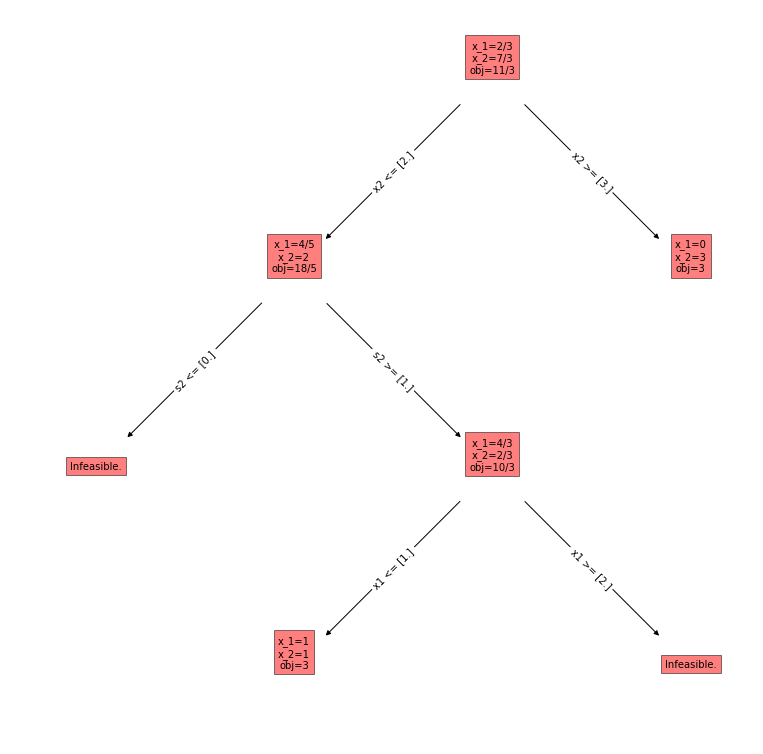

OrderedDict([('x_1', 1.0),
             ('x_2', 1.0),
             ('s_1', 1.0),
             ('s_2', 1.0),
             ('s_3', 1.0),
             ('s_4', 0.0),
             ('s_5', 0.0),
             ('obj', 3.0),
             ('basis', [0, 1, 3, 4, 2]),
             ('z', array([ 0.,  0.,  0.,  0.,  0., -1., -1.])),
             ('optimal_state', 0)])

In [183]:
solver.BranchBound()

In [177]:
solver.nodes

{1: [('x_1', 0.66666667), ('x_2', 2.33333333), ('obj', 3.66666667)],
 2: [('x_1', 0.8), ('x_2', 2.0), ('obj', 3.6)],
 3: [('x_1', 0.0), ('x_2', 3.0), ('obj', 3.0)],
 4: [('obj', nan)],
 5: [('x_1', 1.33333333), ('x_2', 0.66666667), ('obj', 3.33333333)],
 6: [('x_1', 1.0), ('x_2', 1.0), ('obj', 3.0)],
 7: [('obj', nan)]}

In [146]:
pos

{'ROOT': (425.99, 234.0),
 'Child_0': (188.99, 162.0),
 'Grandchild_0': (112.99, 90.0),
 'Greatgrandchild_0': (77.993, 18.0),
 'Child_1': (306.99, 162.0),
 'Grandchild_1': (268.99, 90.0),
 'Greatgrandchild_1': (251.99, 18.0),
 'Child_2': (425.99, 162.0),
 'Grandchild_2': (425.99, 90.0),
 'Greatgrandchild_2': (425.99, 18.0),
 'Child_3': (543.99, 162.0),
 'Grandchild_3': (581.99, 90.0),
 'Greatgrandchild_3': (599.99, 18.0),
 'Child_4': (671.99, 162.0),
 'Grandchild_4': (746.99, 90.0),
 'Greatgrandchild_4': (773.99, 18.0)}